# 02. Neural Network classification with pytorch

Classficiation is a problem of predicting wheter something is one thing or another (there can be multiple things as an option)

## 1. Make  classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


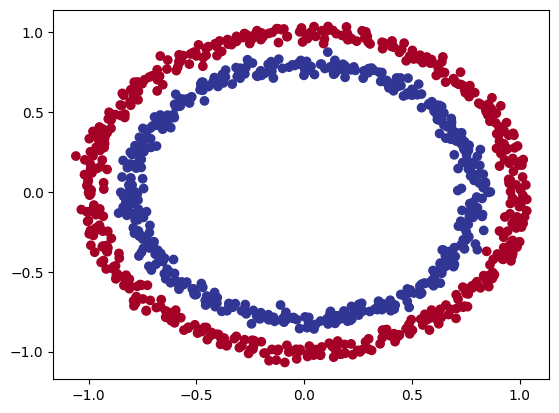

In [6]:
# Visualize
import matplotlib.pyplot as plt 
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: the data were working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X 

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create and train and test splits

In [10]:
# turn data into tensors
import torch

In [11]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Lets build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# 1 Setup 
gpu_name = torch.cuda.get_device_name()
rtx_gpu = "6700" in gpu_name #6700 xt does not do floating point conversion
if torch.cuda.is_available() and not rtx_gpu:
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [17]:
from torch import nn

Now weve setup device agnostic code, lets create a model that:

1. Subclasses `nn.Moeule` (almost all models in pytorch subclass )
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that oulines the forward pass
4. Instatiate an instance our model class and send it to the target `device`

In [18]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features and downscales to single 

    # 3. Define a forward() method that oulines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. instantiate an instance of our model clas and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
next(model_0.parameters()).device

device(type='cpu')

In [20]:
# lets replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Lenght of prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nLenght of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 label:\n{y_test[:10]}")

Lenght of prediction: 200, Shape: torch.Size([200, 1])

Lenght of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.1433],
        [0.0865],
        [0.3690],
        [0.0791],
        [0.4905],
        [0.4548],
        [0.1984],
        [0.2849],
        [0.3635],
        [0.0840]])

First 10 label:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Problem specific

For example for regression you might want MAE or MSE

For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

Loss function to show how off you model is

And for optimizers, two of the most common and useful SGD and Adam however pytorch has many built in options

for this loss function were going to use `torch.nn.BCEWithLogitsLoss()`


In [22]:
# Setup loss function
# loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid prior prior in BCELOSS
loss_fn = torch.nn.BCEWithLogitsLoss() #BCE with Logit has sigmoid activation layer

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [23]:
# calculate accuracy - out of 100 example, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

To train our model, were going to need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multicalss classification).

Then we can convert our models prediction probabilities to **prediction labels** by either rounding them or taking the argmax().


In [24]:
# view first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1433],
        [0.0865],
        [0.3690],
        [0.0791],
        [0.4905]])

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# use the sigmoid activation function on our model logits to turn them into prediction probability
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5358],
        [0.5216],
        [0.5912],
        [0.5198],
        [0.6202]])

For our prediciton probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= .05, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [27]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [29]:
torch.manual_seed(42)

# set the number of epochs
epochs = 1000

# put data to target device
data = [X_train, y_train, X_test, y_test]
for i in data:
    i.to(device)

for epoch in range(epochs):
    ### Training mode
    model_0.train()

    # 1. Forward pass on X_train
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    
    # 2. Calculate the loss y_logits (expect logits since BCEWithLogits) on y_train
    """ for nn.BCELoss 
    loss = loss_fn(torch.sigmoid(y_logits),
                                y_train)

    """

    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input 
                    y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

        # print out whats happening
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%, | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70930, Acc: 50.00%, | Test loss: 0.70085, Test acc: 50.00%
Epoch: 10 | Loss: 0.70015, Acc: 53.87%, | Test loss: 0.69436, Test acc: 57.00%
Epoch: 20 | Loss: 0.69656, Acc: 53.75%, | Test loss: 0.69232, Test acc: 56.50%
Epoch: 30 | Loss: 0.69505, Acc: 52.25%, | Test loss: 0.69183, Test acc: 53.00%
Epoch: 40 | Loss: 0.69434, Acc: 50.62%, | Test loss: 0.69186, Test acc: 52.50%
Epoch: 50 | Loss: 0.69396, Acc: 50.12%, | Test loss: 0.69205, Test acc: 52.00%
Epoch: 60 | Loss: 0.69372, Acc: 50.25%, | Test loss: 0.69229, Test acc: 51.50%
Epoch: 70 | Loss: 0.69355, Acc: 49.75%, | Test loss: 0.69252, Test acc: 51.00%
Epoch: 80 | Loss: 0.69343, Acc: 49.62%, | Test loss: 0.69274, Test acc: 50.00%
Epoch: 90 | Loss: 0.69334, Acc: 50.12%, | Test loss: 0.69295, Test acc: 48.00%
Epoch: 100 | Loss: 0.69327, Acc: 50.25%, | Test loss: 0.69314, Test acc: 46.50%
Epoch: 110 | Loss: 0.69321, Acc: 49.88%, | Test loss: 0.69331, Test acc: 49.00%
Epoch: 120 | Loss: 0.69317, Acc: 49.25%, | Test los

Epoch: 380 | Loss: 0.69298, Acc: 51.00%, | Test loss: 0.69464, Test acc: 46.50%
Epoch: 390 | Loss: 0.69298, Acc: 51.12%, | Test loss: 0.69464, Test acc: 46.50%
Epoch: 400 | Loss: 0.69298, Acc: 51.50%, | Test loss: 0.69465, Test acc: 46.50%
Epoch: 410 | Loss: 0.69298, Acc: 51.62%, | Test loss: 0.69465, Test acc: 46.50%
Epoch: 420 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69466, Test acc: 47.00%
Epoch: 430 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69466, Test acc: 47.00%
Epoch: 440 | Loss: 0.69298, Acc: 51.50%, | Test loss: 0.69466, Test acc: 46.50%
Epoch: 450 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69466, Test acc: 46.00%
Epoch: 460 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69467, Test acc: 45.50%
Epoch: 470 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69467, Test acc: 45.50%
Epoch: 480 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69467, Test acc: 45.50%
Epoch: 490 | Loss: 0.69298, Acc: 51.38%, | Test loss: 0.69467, Test acc: 45.50%
Epoch: 500 | Loss: 0.69298, Acc: 51.12%,

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isnt learning anything...

So to inspect it lets make some prediction and make them visual!

To do so, were going to import a function called `plot_decision_boundary()`

In [30]:
import requests
from pathlib import Path

# download helper function from learn pytorch repo (if not downloaded)
if Path("help_functions.py").is_file():
    print("helper_functions.py already exist, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


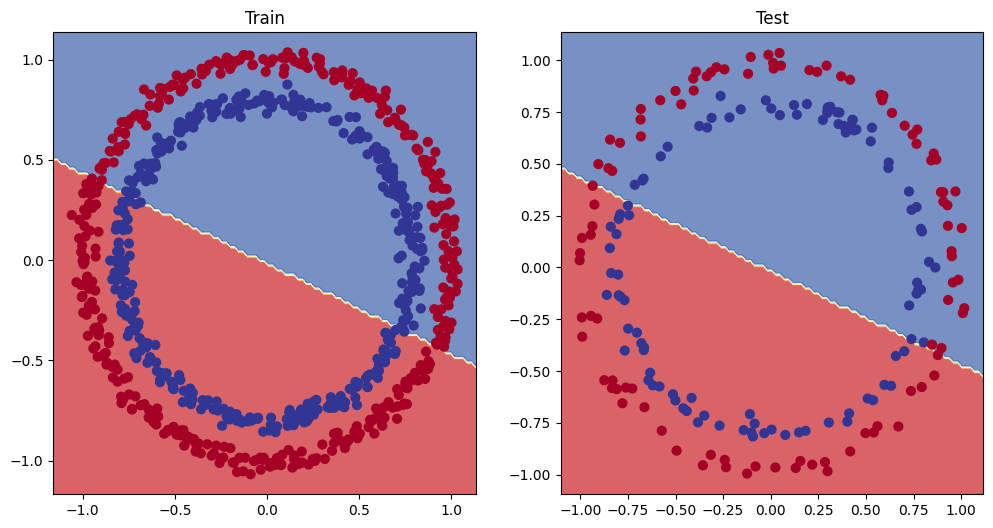

In [31]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about the patterns in the data
* Add more hidden units - go from 5 hidden unit to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a models perspective because they deal directly with the model, rather than the data.

And because these options are all values we ( as ML engineers and data scientist) can change, they are know as **hyperparameters**.

Lets try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000


In [32]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operation leverages speed ups when possible

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() #BCE with Logit has sigmoid activation layer
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [35]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
epochs = 1000

# train for longer
for epoch in range(epochs):
    # train mode
    model_1.train()
    
    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred prob. -> pred labels

    #  2. Calculate the Loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. forward padd
        test_logits = model_1(X_test).squeeze()
        test_pred =torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,
                             y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
    # print out whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


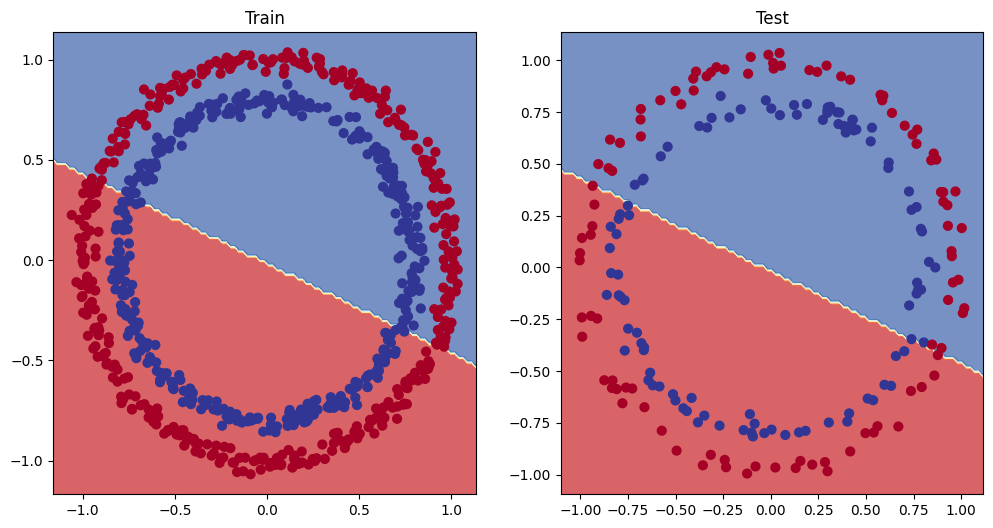

In [36]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)